# State-level Covid-19 Analysis for United States

This notebook utilizes data kindly made available by the JHU Systems Group at 
https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6

and used for their 
[Visual Dashboad](https://www.arcgis.com/apps/opsdashboard/index.html#/bda7594740fd40299423467b48e9ecf6).  It provides a temporal perspective that complements their excellent geospatial presentation.  

The thing about exponentials with a measurable daily growth rate is they change so fast.  With cases increasing 25% per day,a week means a factor of 5 and a month a factor of a thousand.


* Repo for this and other notebnooks at: [https://github.com/deculler/covid19](https://github.com/deculler/covid19)
* Website for this repo: [https://deculler.github.io/covid19/](https://deculler.github.io/covid19/)

## View and run the notebooks

* [View the notebook with nbviewer](https://nbviewer.jupyter.org/github/deculler/covid19/blob/master/US-covid19-JHU.ipynb)
* [Launch it on mybinder.org](https://mybinder.org/v2/gh/deculler/covid19/master?filepath=work/US-covid19-JHU.ipynb)
* [@UCB on datahub.berkeley.edu](http://datahub.berkeley.edu/user-redirect/interact?account=deculler&repo=covid19&branch=master&path=US-covid19-JHU.ipynb)
  
## Quick links to sections

* [Cases by state](#sectionCases)
* [Deaths by state](#sectionDeaths)
* [Growth trends by state](#sectionGrowth)
* [Cases one state](#sectionOneState)
* [Projection of cases in one state](#sectionProj)
* [Projection of deaths in one state](#sectionProjDeath)

The dataset only contains confirmed cases and death, not recoveries.  The data on recoveries tends not to be very good anyways, because case tracking is so poor.  But more importantly, the level of penetration of the virus is still in such an early stage that the eventual balancing out in the SIR models is irrelevant.  With infections growing at 15% per day, if all of today's cases recovered two weeks out, it would only be 1/16th of the new cases.  We are looking at days and weeks, not months and years.

For dataframes it uses Datascience Tables (for reference see http://data8.org/datascience/tables.html) developed for introductory courses as UCB.

In [1]:
# A week, A month, two weeks out ...
1.25**7, 1.25**31, 1.15*14

In [2]:
# HIDDEN
# This useful nonsense should just go at the top of your notebook.
from datascience import *
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plots
import numpy as np
import scipy
plots.style.use('fivethirtyeight')
plots.rc('lines', linewidth=2, color='r')
from ipywidgets import interact
import ipywidgets as widgets
# datascience version number of last run of this notebook
version.__version__

'0.15.0'

In [3]:
import sys
sys.path.append(".")
from timetable import TimeTable

import locale
locale.setlocale( locale.LC_ALL, 'en_US.UTF-8' ) 

import os
import datetime

# Tools for working with timestamps
day_fmt = "%m/%d/%y"

def less_day(day1, day2):
    """Return day1 < day2"""
    return datetime.datetime.strptime(day1, day_fmt) < datetime.datetime.strptime(day2, day_fmt)

def inc_day(day, ndays=1):
    """Return day + ndays"""
    date =  datetime.datetime.strptime(day, day_fmt) + datetime.timedelta(days=ndays)
    return datetime.datetime.strftime(date, day_fmt)

def format_day(day):
    """Return day """
    date =  datetime.datetime.strptime(day, day_fmt)
    return datetime.datetime.strftime(date, day_fmt)

In [4]:
def ave_growth(trend, window=4):
    """Average recent growth rate of single trend"""
    vals = [x for x in trend.take[-window:]['rate'] if np.isfinite(x)]
    return scipy.stats.gmean(vals)


def project_trend(trend, num_days, rate=None, window=4):
    if rate :
        growth_rate = rate
    else :
        growth_rate = ave_growth(trend, window)
        
    day = trend.last('date')
    val = trend.last(1)
    growth = trend.last('new')
    pnew = trend.last('% new')
    proj = trend.copy()
    for i in range(num_days):
        day = inc_day(day)
        growth = round(growth * growth_rate)
        val = val + growth
        pnew = growth/val
        proj.append((day, val, growth, pnew, growth_rate))
    return proj

In [5]:
# Tools specific to the notebook analysis

def make_pname(root, prev):
    return root + "-" + str(prev)

def proj_timeseries(ts, region, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    return project_trend(ts.extract(region).trend(), dist).select(['date', region, 'new'])

def proj2_timeseries(ts, region, prev=2, dist=14, end=None,):
    if not end:
        end = ts['date'][-1]
    proj  = project_trend(ts.extract(region).tail(7+prev).trend(), dist).select(['date', region, 'new'])
    proj1 = project_trend(ts.extract(region).tail(7, prev).trend(), dist+prev).select(['date', region, 'new'])
    proj1.relabel(region, make_pname(region, prev))
    proj1.relabel('new',  make_pname('new', prev))
    combined = TimeTable.from_table(proj.join('date', proj1), time_col = 'date')
    return combined

def proj(ts, region, prev=7, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    proj = proj_timeseries(ts, region, dist, end)
    proj.tail(dist).show()
    proj.select(['date', region, 'new']).tail(prev+dist).plot('date', width = 7)
    plots.plot([end, end], [0, ts[region][-1]])
    _ = plots.xticks(rotation=90)
    
def proj2(ts, region, prev=2, dist=14, end=None):
    if not end:
        end = ts['date'][-1]
    pend = inc_day(end, -prev)
    combined = proj2_timeseries(ts, region, prev, dist, end)
    combined.oplot(height=6, width=6)
    plots.plot([end, end], [0, combined[region][-1]])
    pname = make_pname(region, prev)
    plots.plot([pend, pend], [0, combined[pname][-1]])
    plots.text(end, combined[region][-dist], "{:,}".format(int(combined[region][-dist])))
    plots.text(end, combined[region][-1], "{:,}".format(int(combined[region][-1])))
    plots.text(pend, combined[region][-dist-prev], "{:,}".format(int(combined[region][-dist-prev])))
    plots.text(pend, combined[pname][-1], "{:,}".format(int(combined[pname][-1])))
    combined.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))
    _ = plots.xticks(rotation=90)
    
def get_rates(ts):
    trends = ts.trend()
    rates = trends.extract([x for x in trends.labels if 'rate' in x])
    for label in rates.categories :
        rates.relabel(label, label[5:])
    return rates

In [6]:
def exp_rate(days, s, r):
    return [s*r**day for day in days]

def lin_rate(days, s, r):
    return [s + r*day for day in days]

def fit(model, trend):
    """Fit a 2 paramater model to a rate trend"""
    try :
        doffs = list(range(trend.num_rows))
        params, pcov = scipy.optimize.curve_fit(model, doffs, trend['rate'])
        return params, np.sqrt(np.diag(pcov))
    except :
        return [np.nan, np.nan], [np.nan, np.nan]

def model_rate_trend(trend):
    eparams, epcov = fit(exp_rate, trend)
    doffs = list(range(trend.num_rows))
    t1 = trend.with_column('exp pred', exp_rate(doffs, eparams[0], eparams[1]))
    lparams, lpcov = fit(lin_rate, trend)
    t2 = t1.with_column('lin pred', lin_rate(doffs, lparams[0], lparams[1]))
    return t2, eparams, lparams

def show_model_rate_trend(trend):
    mtrend, eparams, lparams = model_rate_trend(trend)
    print(eparams, lparams)
    mtrend.extract(['exp pred', 'lin pred']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    mtrend.plots[-1].scatter(mtrend['date'], mtrend['rate'])
    mtrend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [7]:
# Daily growth rates

def wgmean(vals):
    xvals = [x for x in vals if np.isfinite(x)]
    try :
        return scipy.stats.gmean(xvals) if xvals else np.nan
    except :
        return np.nan

def growth_rate(trend, window=3):
    """Smooth raw rates"""
    rates = trend['rate']
    vals = np.array((window-1)*[np.nan] + list(rates))
    return [wgmean(vals[i:i+window]) for i in range(len(rates))]

def plot_rate_trend(trend):
    trend = trend.with_column('gm_rate', growth_rate(trend))
    trend.extract(['gm_rate']).oplot(width=8)
    _ = plots.xticks(rotation=90)
    trend.plots[-1].scatter(trend['date'], trend['rate'])
    trend.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))

## Pull Data

URL for https://github.com/nytimes/covid-19-data/blob/master/us-states.csv

In [8]:
stateCasesURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv" 
stateDeathsURL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv" 

In [9]:
raw_states_cases = Table.read_table(stateCasesURL)
raw_states_deaths = Table.read_table(stateDeathsURL)

In [10]:
states_population = raw_states_deaths.select(['Province_State', 'Population']).group('Province_State', sum)
states_population.relabel('Population sum', 'Population')
states_population.relabel('Province_State', 'State')

State,Population
Alabama,4903185
Alaska,731545
American Samoa,55641
Arizona,7278717
Arkansas,3017804
California,39512223
Colorado,5758736
Connecticut,3565287
Delaware,973764
Diamond Princess,0


In [11]:
def population(state):
    return states_population.where('State', state)['Population'][0]

In [12]:
def by_state_cases(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

def by_state_deaths(raw_region):
    """Aggregate state level data from the raw source"""
    res = raw_region.drop(['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Population',
                           'Country_Region', 'Lat','Long_', 'Combined_Key']).group('Province_State', sum)
    
    for lbl in res.labels[1:] :
        res.relabel(lbl, format_day(lbl[:-4]))
    return res

In [13]:
cases_by_state = by_state_cases(raw_states_cases)
deaths_by_state = by_state_deaths(raw_states_deaths)

cases = TimeTable.transpose(cases_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
deaths = TimeTable.transpose(deaths_by_state, 'Province_State', time_col='date', time_less = less_day, time_inc = inc_day)
states = cases.categories

In [14]:
# Last day of rerported data
last_day = cases['date'][-1]
last_day

'04/11/20'

In [15]:
# Number of states/regions reported
len(states)

58

## US National picture

The following graph shows the national picture since the early cases were reported.  States began putting [shelter-in-place measures](https://www.nytimes.com/interactive/2020/us/coronavirus-stay-at-home-order.html) 
in effect March 19 (for California, March 17 for 6 of its counties).

Looking at just the overall number of cases that is when Covid-19 took off in scale.

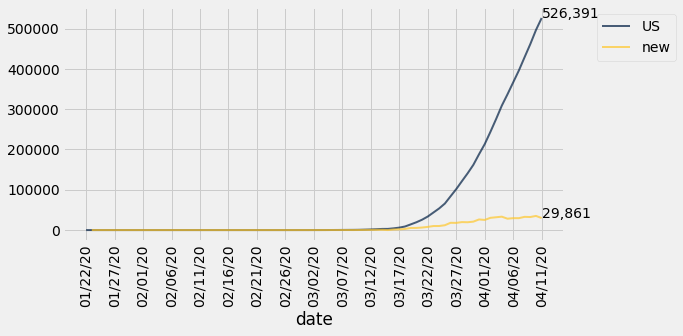

In [16]:
US_cases = cases.select(cases.time_column)
US_cases['US'] = cases.sum_cols()

US_deaths = deaths.select(cases.time_column)
US_deaths['US'] = deaths.sum_cols()

US_case_trend = US_cases.trend()
US_all = US_case_trend.extract(['US', 'new'])
US_all.oplot(width=8)
_ = plots.xticks(rotation=90)
plots.text(US_all.last('date'), US_all.last('US'), "{:,}".format(US_all.last('US')))
plots.text(US_all.last('date'), US_all.last('new'), "{:,}".format(int(US_all.last('new'))))
US_all.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

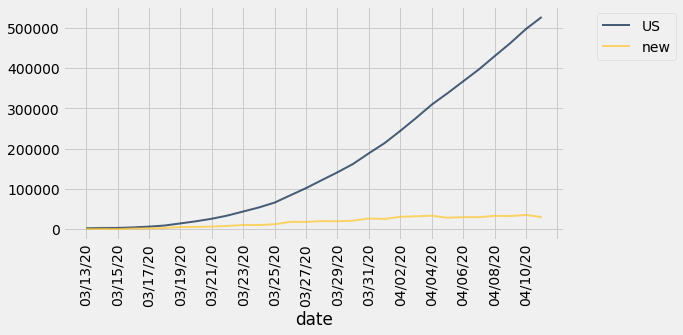

In [17]:
US_recent = US_case_trend.extract(['US', 'new']).after("03/13/20")
US_recent.oplot(width=8)
_ = plots.xticks(rotation=90)
US_recent.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(20))

In [18]:
# percentage of the population confirmed
US_population = sum(states_population['Population'])
"US confirmed cases: {:,} - {:.3%} of {:,} population".format(US_cases['US'][-1], US_cases['US'][-1] / US_population, US_population)

'US confirmed cases: 526,391 - 0.157% of 336,218,660 population'

In [19]:
US_deaths['US'][-1], US_deaths['US'][-1]/US_cases['US'][-1]

(20457, 0.03886274651352322)

## Growth Rates

A much deeper picture is revealed by looking at the day-over-day growth rates across the overall course of the infection.

The daily growth rate had shot up to as muchj as 50% new cases per day for two weeks before the states finally took action.

Since that time it has been dropping steadily as the measures became broader and more consistent.  While still way to fast for the health care systems to manage, it the difference is immense.  At 17% dailey, the number of cases grows by an order of magnitude over two weeks, instead of one,

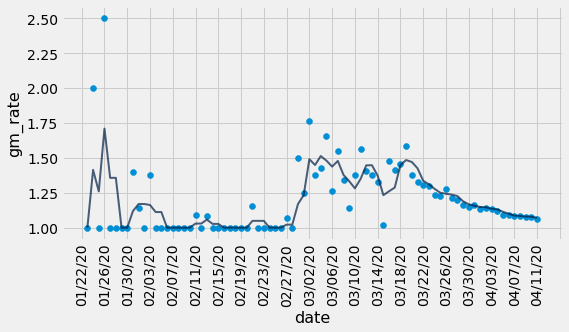

In [20]:
plot_rate_trend(US_case_trend)

Looking at the period since mitigation measures, we find a steadily enough trend that we can hope to model the future enough to attempt predictions.

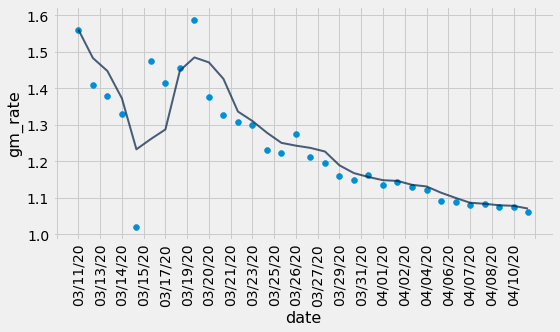

In [21]:
# Past month
plot_rate_trend(US_case_trend.tail(31))

Taking just the past two week, we can get a good fit.  What we are observing here is not the properties of viral infections processes, such as SIR models as more and more of the population gains immunities, it is fundamentally the reduction in transmission rates due to human behavior.  We are still at such minute level of immunity in the population that the classic epidemiological factors hardly matter.  The challenge is what properties should we imbue to such human behavior?  Can we expect linear improvements or is the improvement a continued reduction in the oustanding rate, i.e., exponential.  Over the short term, these cannot be meaningfully differentiated.  Clearly the linear model goes negative whereas the exponential model gradually converges to zero.  The trends are so slow that we need to go out two months (an eternity) to see a notable difference.

[1.17874601 0.99220338] [ 1.1775399  -0.00871434]


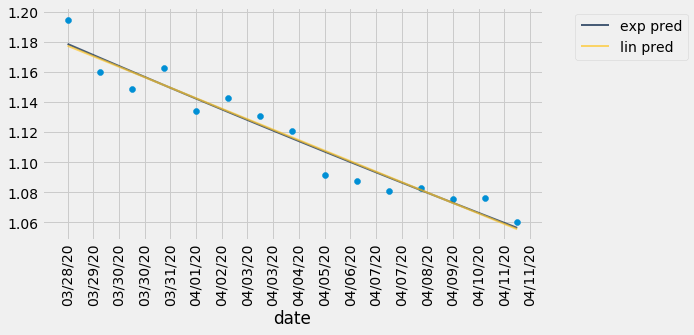

In [22]:
show_model_rate_trend(US_case_trend.tail(14))

In [23]:
US_rate_proj, eparams, lparams = model_rate_trend(US_case_trend.tail(14))

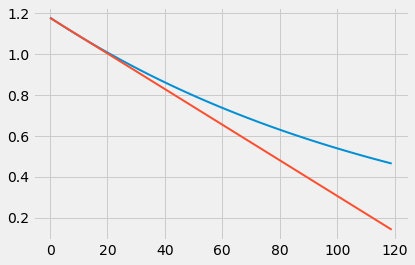

In [24]:
def ahead(n):
    plots.plot(exp_rate(range(n), eparams[0], eparams[1]))
    plots.plot(lin_rate(range(n), lparams[0], lparams[1]))

ahead(120)

## National Projections

Given some predictability, we can project grow rates into the future.  First we look projecting based on the current daily growth rate, modeling what things look like if we do just what we are seeing today, versus how they looked based on what we were seeing some days previously.

Then, given the steady reduction in rates, we project based on projecting the rate improving exponentially.

In [25]:
# Prediction going forward assuming the growth rate remains as it is currently

def proj_US(prev=2, dist=14):
    proj2(US_cases, 'US', prev, dist)
    
_ = interact(proj_US, prev=(0,7,1), dist = (3, 14, 1))

interactive(children=(IntSlider(value=2, description='prev', max=7), IntSlider(value=14, description='dist', m…

In [26]:
def project_progressive_trend(trend, region, num_days):
    day = trend.last(trend.time_column)
    val = trend.last(region)
    new = trend.last('new')
    rate = trend.last('rate')
    params, pcov = fit(exp_rate, trend)
    growths = exp_rate(range(num_days+1), rate, params[1])
    
    proj = trend.select([trend.time_column, region, 'new', 'rate'])
    for i in range(num_days):
        day = inc_day(day)
        rate = growths[i+1]
        new = rate*new
        val = val + new
        pnew = new/val
        proj.append((day, val, new, rate))
    return proj

def proj_prog(ts, region, prev=7, dist=14):
    trend = ts.trend().tail(prev)
    proj = project_progressive_trend(trend, region, dist)
    pproj = proj.select([proj.time_column, region, 'new']).tail(prev+dist)
    pproj.plot('date', width = 8)
    end = trend.last(trend.time_column)
    plots.plot([end, end], [0, trend.last(region)])
    pproj.plots[-1].xaxis.set_major_locator(plots.MaxNLocator(25))
    plots.text(end, trend.last(region), "{:,}".format(trend.last(region)))
    plots.text(pproj.last('date'), pproj.last(region), "{:,}".format(int(pproj.last(region))))
    _ = plots.xticks(rotation=90)

In [27]:
def pproj_US(prev=14, dist=14):
    proj_prog(US_cases, 'US', prev, dist)
    
_ = interact(pproj_US, prev=(0,14,1), dist = (3, 45, 1))



interactive(children=(IntSlider(value=14, description='prev', max=14), IntSlider(value=14, description='dist',…

In [28]:
project_progressive_trend(US_cases.trend().tail(7), 'US', 14).show()

date,US,new,rate
04/04/20,308848,33266,1.12071
04/05/20,337065,28217,1.09136
04/06/20,366660,29595,1.0878
04/07/20,396221,29561,1.08062
04/08/20,429047,32826,1.08285
04/09/20,461432,32385,1.07548
04/10/20,496530,35098,1.07606
04/11/20,526391,29861,1.06014
04/12/20,557862,31470.8,1.05391
04/13/20,590834,32972.6,1.04772


<a id=sectionCases></a>
## Cases to date by state

The following shows the national picture built up state by state.  Only the largest are shown, with the remainder
grouped into 'other'.

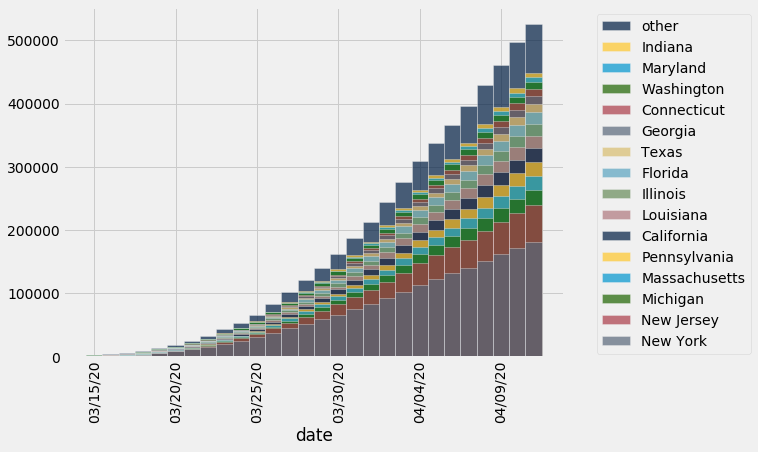

In [29]:
# Total US cases broken down by state
cases.after("03/15/20").stackbar(15, height=6, width=8)
_ = plots.xticks(rotation=90)

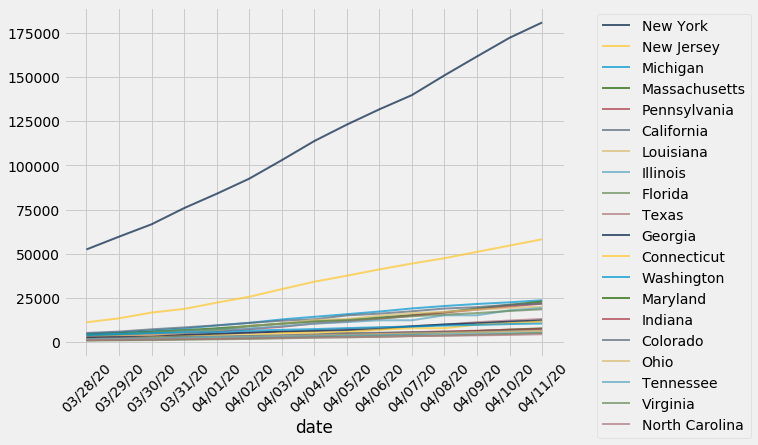

In [30]:
# Cases by state over the past two weeks
cases.top(20).tail(14).plot('date', width=8, height=6)
_ = plots.xticks(rotation=45)

In [31]:
def cases_since(ts, region, threshold=100):
    ctbl = ts.extract(region)
    since = ctbl.where(ctbl[region] >= threshold)
    ndays = since.num_rows
    vals = since[region]
    return vals
        
def show_cases_since(ts, threshold=100, width=8, height=6):
        _, axis = plots.subplots(figsize=(width, height))
        for region in ts.categories :
            vals = cases_since(ts, region, threshold)
            axis.plot(vals)
            axis.text(len(vals), vals[-1], region)

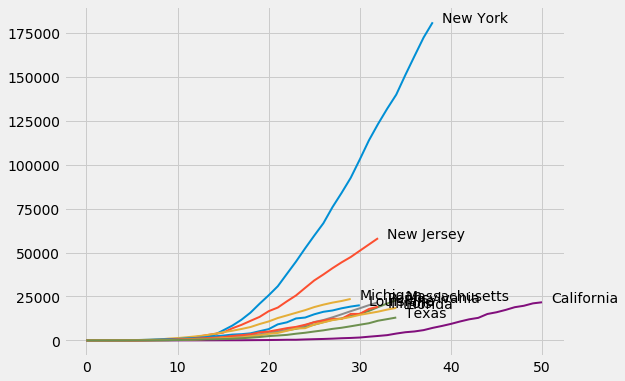

In [32]:
show_cases_since(cases.top(10), 10)

In [33]:
def norm_by_population(ts):
    """Normalize region counts by population in percent"""
    normed = ts.select(ts.time_column)
    for region in ts.categories :
        if population(region) :
            normed[region] = 100*ts[region]/population(region)
    return normed

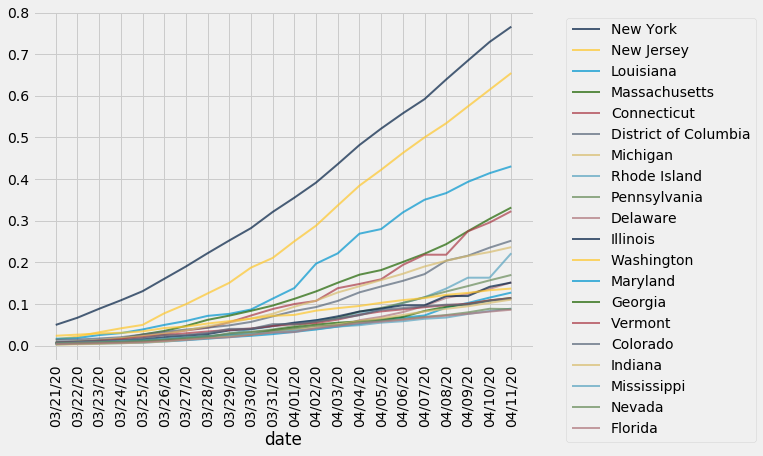

In [34]:
norm_by_population(cases).tail(21).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

<a id='sectionTrends'></a>
## Growth trends by state

An important caveat is that the dirth of testing makes the number of report cases, and particularly the change in that number, messy.  Increased test coverage will tend to increase the number of confirmed cases, whereas containment and mitigation measures may actually be reducing the spread.

The `% new` columns simply look at what fraction of a day's cases are newly reported in that day.  The `rate` columns take the geometric mean of ratio of successive days over a window of the past few days. This provides a little smoothing, but it does not try to project changes in rate.  That is reflected in the series of rates.  Modulo the testing factors, this provides some indication of where measures are working or not.

Death rates are relatively insensitive to the testing error, but are such a lagging indicator they have a limited role in setting expectations for case loads.

In [35]:
cases.order_cols().trend().tail(7)

date,New York,new New York,% newNew York,rate New York,New Jersey,new New Jersey,% newNew Jersey,rate New Jersey,Michigan,new Michigan,% newMichigan,rate Michigan,Massachusetts,new Massachusetts,% newMassachusetts,rate Massachusetts,Pennsylvania,new Pennsylvania,% newPennsylvania,rate Pennsylvania,California,new California,% newCalifornia,rate California,Louisiana,new Louisiana,% newLouisiana,rate Louisiana,Illinois,new Illinois,% newIllinois,rate Illinois,Florida,new Florida,% newFlorida,rate Florida,Texas,new Texas,% newTexas,rate Texas,Georgia,new Georgia,% newGeorgia,rate Georgia,Connecticut,new Connecticut,% newConnecticut,rate Connecticut,Washington,new Washington,% newWashington,rate Washington,Maryland,new Maryland,% newMaryland,rate Maryland,Indiana,new Indiana,% newIndiana,rate Indiana,Colorado,new Colorado,% newColorado,rate Colorado,Ohio,new Ohio,% newOhio,rate Ohio,Tennessee,new Tennessee,% newTennessee,rate Tennessee,Virginia,new Virginia,% newVirginia,rate Virginia,North Carolina,new North Carolina,% newNorth Carolina,rate North Carolina,Missouri,new Missouri,% newMissouri,rate Missouri,Arizona,new Arizona,% newArizona,rate Arizona,Alabama,new Alabama,% newAlabama,rate Alabama,Wisconsin,new Wisconsin,% newWisconsin,rate Wisconsin,South Carolina,new South Carolina,% newSouth Carolina,rate South Carolina,Nevada,new Nevada,% newNevada,rate Nevada,Mississippi,new Mississippi,% newMississippi,rate Mississippi,Rhode Island,new Rhode Island,% newRhode Island,rate Rhode Island,Utah,new Utah,% newUtah,rate Utah,Oklahoma,new Oklahoma,% newOklahoma,rate Oklahoma,District of Columbia,new District of Columbia,% newDistrict of Columbia,rate District of Columbia,Kentucky,new Kentucky,% newKentucky,rate Kentucky,Iowa,new Iowa,% newIowa,rate Iowa,Delaware,new Delaware,% newDelaware,rate Delaware,Minnesota,new Minnesota,% newMinnesota,rate Minnesota,Idaho,new Idaho,% newIdaho,rate Idaho,Oregon,new Oregon,% newOregon,rate Oregon,Kansas,new Kansas,% newKansas,rate Kansas,Arkansas,new Arkansas,% newArkansas,rate Arkansas,New Mexico,new New Mexico,% newNew Mexico,rate New Mexico,New Hampshire,new New Hampshire,% newNew Hampshire,rate New Hampshire,Puerto Rico,new Puerto Rico,% newPuerto Rico,rate Puerto Rico,Vermont,new Vermont,% newVermont,rate Vermont,Nebraska,new Nebraska,% newNebraska,rate Nebraska,South Dakota,new South Dakota,% newSouth Dakota,rate South Dakota,Maine,new Maine,% newMaine,rate Maine,West Virginia,new West Virginia,% newWest Virginia,rate West Virginia,Hawaii,new Hawaii,% newHawaii,rate Hawaii,Montana,new Montana,% newMontana,rate Montana,North Dakota,new North Dakota,% newNorth Dakota,rate North Dakota,Wyoming,new Wyoming,% newWyoming,rate Wyoming,Alaska,new Alaska,% newAlaska,rate Alaska,Guam,new Guam,% newGuam,rate Guam,Grand Princess,new Grand Princess,% newGrand Princess,rate Grand Princess,Virgin Islands,new Virgin Islands,% newVirgin Islands,rate Virgin Islands,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Northern Mariana Islands,new Northern Mariana Islands,% newNorthern Mariana Islands,rate Northern Mariana Islands,American Samoa,new American Samoa,% newAmerican Samoa,rate American Samoa
04/04/20,113833,10846,0.0952799,1.10531,34124,4229,0.12393,1.14146,14225,1481,0.104112,1.11621,11736,1334,0.113667,1.12824,10444,1874,0.179433,1.21867,12837,833,0.0648906,1.06939,12496,2199,0.175976,1.21356,10357,1453,0.140292,1.16319,11537,1269,0.109994,1.12359,6567,833,0.126846,1.14527,6160,329,0.0534091,1.05642,5276,362,0.0686126,1.07367,7247,401,0.0553332,1.05857,3125,367,0.11744,1.13307,3953,516,0.130534,1.15013,4188,446,0.106495,1.11919,3739,427,0.114202,1.12893,3322,255,0.076761,1.08314,2407,395,0.164105,1.19632,2486,235,0.0945294,1.1044,2310,446,0.193074,1.23927,2187,250,0.114312,1.12907,1614,119,0.0737299,1.0796,2030,18,0.008867,1.00895,1917,217,0.113198,1.12765,1742,228,0.130884,1.15059,1455,97,0.0666667,1.07143,806,95,0.117866,1.13361,1432,179,0.125,1.14286,1161,171,0.14728

In [36]:
def rate_change(ts, region_type, prev=7):
    rates   = get_rates(ts)
    regions = ts.categories
    current = rates.row(-1)[1:]
    older   = rates.row(-1-prev)[1:]
    return Table().with_columns(region_type, regions,
                                'rate', current, 
                                make_pname('rate', prev), older)

def show_rate_change(ts, region_type, prev=7):
    rc = rate_change(ts, region_type, prev)
    rc.drop(0).scatter('rate')
    plots.plot([ min(rc['rate']), max(rc['rate']) ], [ min(rc['rate']), max(rc['rate']) ])

The interactive chart below shows for each state the current growth rate (horizontal) versus the growth rate some days previous.  The distance able the line shows how much the growth rate has improved, below the line the growth rate is getting worse.  Gives a sense of how the measures are working.

In [37]:
def irate(previous=7):
    show_rate_change(cases, 'State', previous)

_ = interact(irate, previous = (1,28,1))

interactive(children=(IntSlider(value=7, description='previous', max=28, min=1), Output()), _dom_classes=('wid…

<a id=sectionDeaths></a>
## Deaths to date by state

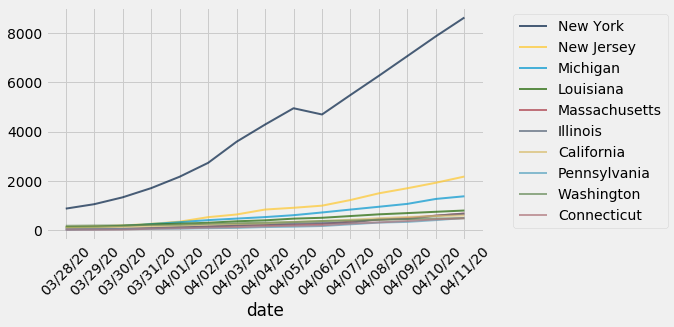

In [38]:
deaths.top(10).tail(14).plot('date', width=7)
_ = plots.xticks(rotation=45)

In [39]:
deaths.order_cols().trend().tail(7)

date,New York,new New York,% newNew York,rate New York,New Jersey,new New Jersey,% newNew Jersey,rate New Jersey,Michigan,new Michigan,% newMichigan,rate Michigan,Louisiana,new Louisiana,% newLouisiana,rate Louisiana,Massachusetts,new Massachusetts,% newMassachusetts,rate Massachusetts,Illinois,new Illinois,% newIllinois,rate Illinois,California,new California,% newCalifornia,rate California,Pennsylvania,new Pennsylvania,% newPennsylvania,rate Pennsylvania,Washington,new Washington,% newWashington,rate Washington,Connecticut,new Connecticut,% newConnecticut,rate Connecticut,Florida,new Florida,% newFlorida,rate Florida,Georgia,new Georgia,% newGeorgia,rate Georgia,Indiana,new Indiana,% newIndiana,rate Indiana,Texas,new Texas,% newTexas,rate Texas,Colorado,new Colorado,% newColorado,rate Colorado,Ohio,new Ohio,% newOhio,rate Ohio,Maryland,new Maryland,% newMaryland,rate Maryland,Wisconsin,new Wisconsin,% newWisconsin,rate Wisconsin,Virginia,new Virginia,% newVirginia,rate Virginia,Missouri,new Missouri,% newMissouri,rate Missouri,Arizona,new Arizona,% newArizona,rate Arizona,Tennessee,new Tennessee,% newTennessee,rate Tennessee,Nevada,new Nevada,% newNevada,rate Nevada,Oklahoma,new Oklahoma,% newOklahoma,rate Oklahoma,Mississippi,new Mississippi,% newMississippi,rate Mississippi,Alabama,new Alabama,% newAlabama,rate Alabama,Kentucky,new Kentucky,% newKentucky,rate Kentucky,North Carolina,new North Carolina,% newNorth Carolina,rate North Carolina,South Carolina,new South Carolina,% newSouth Carolina,rate South Carolina,Minnesota,new Minnesota,% newMinnesota,rate Minnesota,Rhode Island,new Rhode Island,% newRhode Island,rate Rhode Island,Kansas,new Kansas,% newKansas,rate Kansas,Oregon,new Oregon,% newOregon,rate Oregon,District of Columbia,new District of Columbia,% newDistrict of Columbia,rate District of Columbia,Puerto Rico,new Puerto Rico,% newPuerto Rico,rate Puerto Rico,Iowa,new Iowa,% newIowa,rate Iowa,Delaware,new Delaware,% newDelaware,rate Delaware,Arkansas,new Arkansas,% newArkansas,rate Arkansas,Idaho,new Idaho,% newIdaho,rate Idaho,Vermont,new Vermont,% newVermont,rate Vermont,New Hampshire,new New Hampshire,% newNew Hampshire,rate New Hampshire,Maine,new Maine,% newMaine,rate Maine,New Mexico,new New Mexico,% newNew Mexico,rate New Mexico,Nebraska,new Nebraska,% newNebraska,rate Nebraska,Utah,new Utah,% newUtah,rate Utah,Alaska,new Alaska,% newAlaska,rate Alaska,Hawaii,new Hawaii,% newHawaii,rate Hawaii,North Dakota,new North Dakota,% newNorth Dakota,rate North Dakota,Montana,new Montana,% newMontana,rate Montana,South Dakota,new South Dakota,% newSouth Dakota,rate South Dakota,Guam,new Guam,% newGuam,rate Guam,West Virginia,new West Virginia,% newWest Virginia,rate West Virginia,Grand Princess,new Grand Princess,% newGrand Princess,rate Grand Princess,Northern Mariana Islands,new Northern Mariana Islands,% newNorthern Mariana Islands,rate Northern Mariana Islands,Virgin Islands,new Virgin Islands,% newVirgin Islands,rate Virgin Islands,American Samoa,new American Samoa,% newAmerican Samoa,rate American Samoa,Diamond Princess,new Diamond Princess,% newDiamond Princess,rate Diamond Princess,Wyoming,new Wyoming,% newWyoming,rate Wyoming
04/04/20,4290,696,0.162238,1.19366,846,200,0.236407,1.3096,540,61,0.112963,1.12735,409,39,0.0953545,1.10541,216,24,0.111111,1.125,244,34,0.139344,1.1619,289,24,0.083045,1.09057,136,34,0.25,1.33333,315,24,0.0761905,1.08247,165,34,0.206061,1.25954,195,25,0.128205,1.14706,201,17,0.0845771,1.09239,116,14,0.12069,1.13725,116,16,0.137931,1.16,111,14,0.126126,1.14433,102,11,0.107843,1.12088,54,11,0.203704,1.25581,54,3,0.0555556,1.05882,52,6,0.115385,1.13043,33,8,0.242424,1.32,52,11,0.211538,1.26829,50,9,0.18,1.21951,46,3,0.0652174,1.06977,42,4,0.0952381,1.10526,35,6,0.171429,1.2069,44,6,0.136364,1.15789,40,6,0.15,1.17647,34,7,0.205882,1.25926,40,6,0.15,1.17647,24,2,0.0833333,1.09091,17,3,0.176471,1.21429,21,3,0.142857,1.16667,22,0,0,1,21,6,0.285714,1.4,18,3,0.166667,1.2,14,3,0.214286,1.27273

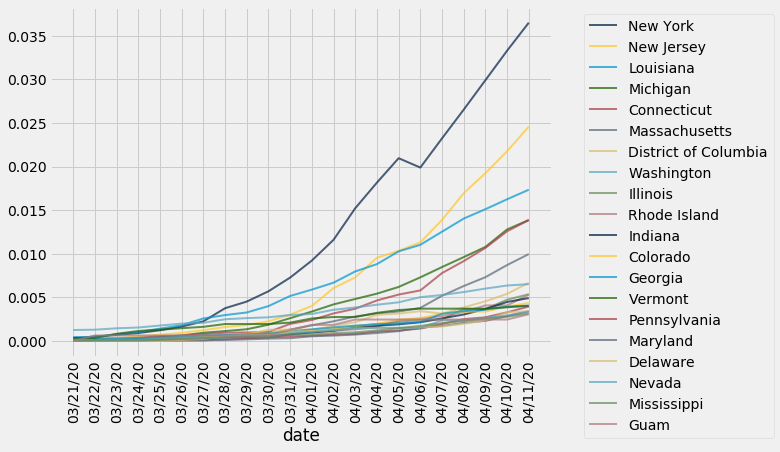

In [40]:
norm_by_population(deaths).tail(21).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

<a id='sectionOneState'></a>
## Cases in one state

These sections of the notebook allow diving into the picture for a particular state.  We start with the basic trends and then look at projects up to a couple weeks out.  Things are changing so rapidly, it is pretty meaningless to talk about numbers farther out than that.  Whereas just looking at the short term puts in stark relief how rapidly we need to move in preparing to care for infected people.

In [41]:
def show_st(state='California', prev = 7):
    cases.extract(state).trend().tail(prev).show()
    cases.extract(state).trend().extract([state, 'new']).tail(21).plot('date', width=7)
    _ = plots.xticks(rotation=90)
    plot_rate_trend(cases.extract(state).trend().tail(prev))
    _ = plots.xticks(rotation=90)

_ = interact(show_st, state=states, prev = (7, 21, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

<a id='sectionProj'></a>
## Projection of cases in one state

To look forward at what the story may be over the coming days, we project forward the recent growth rate.  This may be pessimistic if measures are working and the rate is improving.  But, the rate of change in the rate is low enough and the variability due to external factors high enough that any more sophisticated method seems dubious.

The vertical line shows where we are today.

In [42]:
def proj_st(state='California', dist=14):
    proj(cases, state, 7, dist)
    
_ = interact(proj_st, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

In [43]:
def proj_prog_st(state='California', dist=14):
    proj_prog(cases.extract(state), state, 7, dist)
    
_ = interact(proj_prog_st, state=states, dist = (7, 31, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

<a id='sectionProjDeath'></a>
## Projection of deaths in one state

In [44]:
def proj_st_deaths(state='California', dist=14):
    proj(deaths, state, 7, dist)

_ = interact(proj_st_deaths, state=states, dist = (7, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

## Are the projections changing with mitigation measures?

We are seeing reductions in growth rates as communities adopt shelter in place and other isolation measures.  How does out prediction today for two weeks out differ from what we would have made yesterday for 15 days out?  

This graph shows the project based on the most current data and compares it to the projection based on
`prev` days ago.  If measures are succeeding, we should see improvements relative to `-prev`.  The distance of projection is adjustable.

In [45]:
def proj2_st(state='California', prev=2, dist=14):
    proj2(cases, state, prev, dist)
    
_ = interact(proj2_st, state=states, prev=(0,7,1), dist=(3, 14, 1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

In [46]:
def proj2_st_deaths(state='California', prev=2):
    proj2(deaths, state, prev)
    
_ = interact(proj2_st_deaths, state=states, prev=(0,7,1))

interactive(children=(Dropdown(description='state', index=5, options=('Alabama', 'Alaska', 'American Samoa', '…

## Changes in case rates

Here we try to get a handle on the spread of rates and whether they are improving.

In [47]:
get_rates(cases).tail(7)

date,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Diamond Princess,District of Columbia,Florida,Georgia,Grand Princess,Guam,Hawaii,Idaho,Illinois,Indiana,Iowa,Kansas,Kentucky,Louisiana,Maine,Maryland,Massachusetts,Michigan,Minnesota,Mississippi,Missouri,Montana,Nebraska,Nevada,New Hampshire,New Jersey,New Mexico,New York,North Carolina,North Dakota,Northern Mariana Islands,Ohio,Oklahoma,Oregon,Pennsylvania,Puerto Rico,Rhode Island,South Carolina,South Dakota,Tennessee,Texas,Utah,Vermont,Virgin Islands,Virginia,Washington,West Virginia,Wisconsin,Wyoming
04/04/20,1.0796,1.08917,nan,1.12907,1.0554,1.06939,1.11919,1.07367,1.31778,1,1.19155,1.12359,1.05642,1,1.10714,1.10031,1.14703,1.16319,1.15013,1.12589,1.1097,1.19091,1.21356,1.05556,1.13307,1.12824,1.11621,1.09772,1.07143,1.23927,1.09053,1.15054,1.15059,1.12735,1.14146,1,1.10531,1.1044,1.07514,1,1.12893,1.17273,1,1.21867,1.43038,1.13361,1.12765,1.13369,1.08314,1.14527,1.14286,1.18509,1.08108,1.19632,1.05857,1.18987,1.00895,1.15432
04/05/20,1.09356,1.08187,nan,1.13672,1.12651,1.17115,1.18195,1.07563,1.13491,1,1.11086,1.07047,1.07906,1,1.2043,1.05698,1.05479,1.08709,1.11586,1.10419,1.07593,1.04144,1.04113,1.0307,1.15744,1.0651,1.10496,1.08092,1.12577,1.01602,1.07925,1.13396,1.06487,1.15,1.09908,1.25468,1.08194,1.06557,1.1129,1,1.08131,1.0801,1.18799,1.10963,1.05088,1.14392,1.06886,1.13208,1.09362,1.09776,1.11941,1.11063,1.05,1.0968,1.07976,1.14894,1.14286,1.05348
04/06/20,1.10595,1.02703,nan,1.09895,1.0454,1.06552,1.04707,1.21692,1.16345,1,1.09481,1.07887,1.10035,1,1.00893,1.04313,1.02134,1.08908,1.12355,1.08861,1.13049,1,1.14274,1.0617,1.11833,1.10696,1.09562,1.05455,1.06105,1.16574,1.04545,1.1456,1.05283,1.15137,1.09559,1.12985,1.07027,1.11816,1.08696,1,1.10141,1.05981,1,1.13271,1.08,1.17354,1.08931,1.2,1.04652,1.11569,1.04803,1.06055,1.02381,1.09015,1.06211,1.06481,1.0556,1.06599
04/07/20,1.11117,1.12105,nan,1.05051,1.08114,1.08315,1.04746,1.1267,1.18519,1,1.10392,1.09164,1.20618,1,1.0708,1.05943,1.06267,1.00073,1.11178,1.10571,1.0742,1.20314,1.09531,1.04008,1.08059,1.09865,1.10156,1.08418,1.10184,1.14401,1.06689,1.07194,1.08756,1,1.08094,1.1572,1.06115,1.11377,1.05333,1,1.07388,1.1091,1.05993,1.13148,1.11696,1.13586,1.08289,1.11111,1.08864,1.10966,1.03929,1.05893,1,1.15879,1.04584,1.1942,1.05267,1.02857
04/08/20,1.07331,1.06103,nan,1.05784,1.05708,1.0891,1.04163,1,1.20259,1,1.1891,1.06263,1.12231,1,1,1,1.03419,1.22875,1.07858,1.09465,1.14693,1,1.04581,1.03468,1.26493,1.10446,1.07254,1.07951,1.04595,1.02524,1.04075,1.16107,1.06356,1.04476,1.06802,1.02968,1.07997,1.06062,1.05907,1,1.07654,1.03528,1.04329,1.11971,1.08202,1.17982,1,1.22812,1.05412,1.09546,1.06243,1.05217,1.04651,1.09295,1.06719,1.17233,1.0512,1.02315
04/09/20,1.16108,1.03982,nan,0.994071,1.119,1.04302,1,1.25742,1.08333,1,1.05764,1.05875,1.06716,1,1.05785,1.07805,1.01818,1.00007,1.06865,1.10917,1.06692,1.1671,1.07358,1.04283,1.11865,1.12811,1.05692,1.07452,1.12831,1.06949,1.06627,1.09441,1.08721,1.09639,1.07568,0.95898,1.07095,1.06773,1.07171,1,1.07071,1.10485,1.11854,1.10035,1.10161,1.19103,1.15556,1.1374,1.06211,1.14636,1.00054,1.03802,1,1.10892,1.03913,1.06418,1.06494,1.04072
04/10/20,1.09027,1.04681,nan,1.03115,1.04647,1.06956,1.09673,1.07706,1.09677,1,1.08995,1.07132,1.08698,1,1.01562,1,1.09903,1.18622,1.08755,1.09291,1.0009,1.26249,1.05305,1.04643,1.1266,1.10733,1.04325,1.07742,1.09248,1.13549,1.03107,1.11796,1.10831,1,1.06979,1.24971,1.06533,1.0613,1.03346,1,1.0664,1.06406,1.00076,1.09568,1.06149,1,1.0981,1.19911,1.05546,1.08003,1.13308,1.08121,1.11111,1.11554,1.0498,1.11673,1.06306,1.03913
04/11/20,1.09162,1.04472,nan,1.0903,1.04868,1.02965,1.05015,1.09224,1.11538,1,1.07108,1.05493,1.05869,1,1.02308,1.05204,1.03102,1.07229,1.07644,1.0879,1.14145,1,1.03953,1.05119,1.10419,1.08992,1.0522,1.06811,1.07007,1.05414,1.03288,1.10079,0.992652,1.08059,1.06527,1.00925,1.05035,1.09811,1.05396,1,1.06329,1.04125,1.03707,1.08319,1.0869,1.36016,1.04695,1.16791,1.04927,1.07584,1.04

In [ ]:
get_rates(cases).tail(14).top(20).oplot(height=6, width=8)
_ = plots.xticks(rotation=90)

In [ ]:
_ = plots.hist(get_rates(cases).take[-1].row(0)[1:], bins=20)

In [ ]:
def best_rate(ts, n):
    rates = get_rates(ts).tail(7).order_cols()
    best = rates.labels[-n:]
    return rates.extract(best)

In [ ]:
best_rate(cases, 12)

In [ ]:
def get_new(trend, region):
    return trend['new ' + region][-1]

def get_rate(trend, region):
    return trend['rate ' + region][-1]

def get_val(trend, region):
    return trend[region][-1]

def get_rate_slope(trend, region):
    params, pcov = fit(lin_rate, trend)
    return params[1]

def summary(ts, name, regions):
    trend = ts.trend()
    smry = Table().with_columns(
        name, regions,
        'current', [get_val(trend, r) for r in regions],
        'new',  [get_new(trend, r) for r in regions],
        'rate', [get_rate(trend, r) for r in regions],
    )
    params = [fit(lin_rate, ts.extract(r).trend().tail(7)) for r in regions]
    smry['eff rate'] = [p[0][0] for p in params]
    smry['delta']    = [p[0][1] for p in params]
    smry['err']      = [p[1][1] for p in params]
    return smry.where(np.isfinite(smry['err']))

In [ ]:
case_sum = summary(cases, 'state', states)
case_sum.sort('delta', descending=True)

In [ ]:
case_sum.select('state', 'delta').sort('delta').scatter('state', width=12)
_ = plots.xticks(rotation=90)

In [ ]:
case_sum.scatter('current', 'rate')

In [ ]:
case_sum.scatter('current', 'delta')